# Final Project

First we need to open the dataset and look at what data is available

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
import seaborn as sns
from matplotlib import rcParams
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import matplotlib.patches as mpatches
from sklearn import linear_model
import geopandas
import shapely.speedups


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
import datetime as dt
import contextily as cx
%matplotlib inline

C:\Users\nhdez\miniconda3\envs\gds\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
city_references = ['london', 'paris', 'losangeles', 'melbourne', 'tokyo']

In [3]:
#OPEN ALL CITY FILES   
open_files1 = "./data/cities/{}.csv".format(city_references[0])
open_files2 = "./data/cities/{}.csv".format(city_references[1])
open_files3 = "./data/cities/{}.csv".format(city_references[2])
open_files4 = "./data/cities/{}.csv".format(city_references[3])
open_files5 = "./data/cities/{}.csv".format(city_references[4])


data_london = pd.read_csv(open_files1).iloc[: , 1:]
data_paris = pd.read_csv(open_files2).iloc[: , 1:]
data_la = pd.read_csv(open_files3).iloc[: , 1:]
data_melbourne = pd.read_csv(open_files4).iloc[: , 1:]
data_tokyo = pd.read_csv(open_files5).iloc[: , 1:]


#convert column 'day' from object to machine recognized date shape
data_london.day = pd.to_datetime(data_london['day'], format = '%Y-%m-%d')
data_paris.day = pd.to_datetime(data_paris['day'], format = '%Y-%m-%d')
data_la.day = pd.to_datetime(data_la['day'], format = '%Y-%m-%d')
data_melbourne.day = pd.to_datetime(data_melbourne['day'], format = '%Y-%m-%d')
data_tokyo.day = pd.to_datetime(data_tokyo['day'], format = '%Y-%m-%d')

Cities that are chosen:
* London
* Paris
* Los Angeles
* Taipeh
* Melbourne

In [4]:
#OPEN DETECTOR DATA
DIR_detectors = "./data/detectors_public.csv"

geo_detectors = pd.read_csv(DIR_detectors)
geo_detectors_london = geo_detectors.loc[geo_detectors.citycode == 'london']
geo_detectors_paris = geo_detectors.loc[geo_detectors.citycode == 'paris']
geo_detectors_la = geo_detectors.loc[geo_detectors.citycode == 'losanageles']
geo_detectors_melbourne = geo_detectors.loc[geo_detectors.citycode == 'losanageles']
geo_detectors_tokyo = geo_detectors.loc[geo_detectors.citycode == 'tokyo']

# Now go from Longitude and Latitude to geometric datapoints

In [5]:
gdf_london = geopandas.GeoDataFrame(
    geo_detectors_london, geometry=geopandas.points_from_xy(geo_detectors_london.long, geo_detectors_london.lat))
gdf_paris = geopandas.GeoDataFrame(
    geo_detectors_paris, geometry=geopandas.points_from_xy(geo_detectors_paris.long, geo_detectors_paris.lat))
gdf_la = geopandas.GeoDataFrame(
    geo_detectors_la, geometry=geopandas.points_from_xy(geo_detectors_la.long, geo_detectors_la.lat))
gdf_melbourne = geopandas.GeoDataFrame(
    geo_detectors_melbourne, geometry=geopandas.points_from_xy(geo_detectors_melbourne.long, geo_detectors_melbourne.lat))
gdf_tokyo = geopandas.GeoDataFrame(
    geo_detectors_tokyo, geometry=geopandas.points_from_xy(geo_detectors_tokyo.long, geo_detectors_tokyo.lat))

In [6]:
#OPEN GEOGRAPHIC DATA
path_london = "./data/geomaps/London.json"
path_paris = "./data/geomaps/Paris.geojson"
path_la = "./data/geomaps/LA2.geojson"
path_melbourne = "./data/geomaps/Melbourne.geojson"
path_tokyo = "./data/geomaps/Tokyo.geojson"


# Read data
geo_london = gpd.read_file(path_london)
geo_paris = gpd.read_file(path_paris)
geo_la = gpd.read_file(path_la)
geo_melbourne = gpd.read_file(path_melbourne)
geo_tokyo = gpd.read_file(path_tokyo)

<AxesSubplot:>

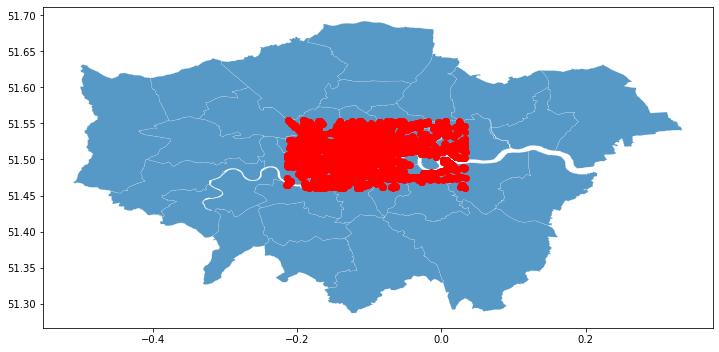

In [7]:
f, ax =plt.subplots(1, figsize=(12,12))

geo_london.plot(alpha = 0.75, linewidth = 0.2, edgecolor = 'white', ax=ax)
gdf_london.plot(color = 'red',ax=ax)

# ax[1] = geo_paris.plot(alpha = 0.75, linewidth = 0.2, edgecolor = 'white', ax=ax)
# ax[1] = gdf_paris.plot(color = 'red',ax=ax)

In [8]:
def count_points_in_neighborhoods (list_of_neighborhoods , list_of_points , threshold):
    x = list_of_neighborhoods
    zero = np.zeros(list_of_neighborhoods.shape[0])
    for i in range(list_of_points.shape[0]):
        true = list_of_neighborhoods.geometry.contains(list_of_points.geometry.iloc[i])
        zero[np.where(true)]+=1
    x['count'] = zero 
    
    return x , x.index[x['count'] > threshold].tolist()

threshold = 0

(-0.5525946011260479,
 0.37623509511498987,
 51.266504458163965,
 51.71212980719943)

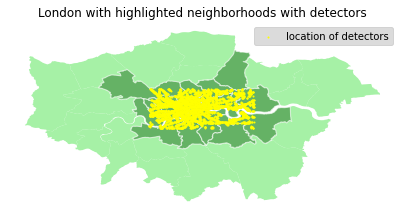

In [9]:
neighborhood_count_london, list_of_possible_neighborhoods_london = count_points_in_neighborhoods (geo_london,gdf_london,threshold)
rest_london = neighborhood_count_london[~neighborhood_count_london.index.isin(list_of_possible_neighborhoods_london)].iloc[:,:-1]
useful_london = neighborhood_count_london[neighborhood_count_london.index.isin(list_of_possible_neighborhoods_london)]

#PLOTTING FOR LONDON
fig, ax = plt.subplots(1, figsize=(7,7))
rest_london.plot(alpha = 0.8, color = 'lightgreen', ax=ax, label = 'neighborhoods with less than {} detectors'.format(threshold+1))
useful_london.plot(alpha = 0.6, color = 'green', ax=ax, label = 'relevent neighborhoods', edgecolor = "white", linewidth=1.1)
gdf_london.plot(markersize=1, color='yellow', ax=ax, label = 'location of detectors')
ax.legend(facecolor="lightgray")
ax.set_title('London with highlighted neighborhoods with detectors')
plt.axis('off')

In [47]:
# neighborhood_count_tokyo, list_of_possible_neighborhoods_tokyo = count_points_in_neighborhoods (geo_tokyo,gdf_tokyo,threshold)
# rest_data = neighborhood_count_tokyo[~neighborhood_count_tokyo.index.isin(list_of_possible_neighborhoods_tokyo)].iloc[:,:-1]
# useful_data = neighborhood_count_tokyo[neighborhood_count_tokyo.index.isin(list_of_possible_neighborhoods_tokyo)]

# #PLOTTING FOR TOKYO
# fig, ax = plt.subplots(1, figsize=(7,7))
# rest_data.plot(alpha = 0.8, color = 'lightgreen', ax=ax, label = 'neighborhoods with less than {} detectors'.format(threshold+1))
# useful_data.plot(alpha = 0.6, color = 'green', ax=ax, label = 'relevent neighborhoods', edgecolor = "white", linewidth=1.1)
# gdf_tokyo.plot(markersize=1, color='yellow', ax=ax, label = 'location of detectors')
# ax.legend(facecolor="lightgray")
# ax.set_title('Tokyo with highlighted neighborhoods with detectors')
# plt.axis('off')

In [10]:
def add_neighborhoods (list_of_neighborhoods , list_of_points):
    x = list_of_neighborhoods
    zero = np.zeros(list_of_neighborhoods.shape[0])
    for i in range(list_of_points.shape[0]):
        true = list_of_neighborhoods.geometry.contains(list_of_points.geometry.iloc[i])
        zero[np.where(true)]+=1
    x['count'] = zero 
    
    return x , x.index[x['count'] > threshold].tolist()

threshold = 0

In [11]:
def add_neighborhood_to_gdf(list_of_neighborhoods, list_of_points, threshold):
    list_neighborhoods_count, list_with_valid_neighborhoods = count_points_in_neighborhoods (list_of_neighborhoods , list_of_points , threshold)
    data_valid_neighborhoods = neighborhood_count_london.loc[list_with_valid_neighborhoods]
    list_of_points = list_of_points.reset_index(drop = True)
    list_of_points['neighborhood'] = np.nan
    for i in range(len(list_with_valid_neighborhoods)):
        neighborhood_index = np.where(list_of_points.geometry.within(data_valid_neighborhoods.geometry.iloc[i]))
        list_of_points['neighborhood'].loc[neighborhood_index] = data_valid_neighborhoods.name.iloc[i]
    return list_of_points  

In [12]:
def flow_per_day_in_neighborhood(neighborhood_data):
    unique_days = neighborhood_data.day.unique()
    
    neighborhood_data_day = neighborhood_data.loc[neighborhood_data.day == unique_days[0]][['detid','interval','flow','neighborhood']]
    
    for i in range(1,len(unique_days)):
        neighborhood_data_day2 = neighborhood_data.loc[neighborhood_data.day == unique_days[i]][['detid','interval','flow']]
        neighborhood_data_day = pd.merge(neighborhood_data_day,neighborhood_data_day2,
                                        left_on = ['detid','interval'], right_on = ['detid','interval'])
    neighborhood_data_day["average flow"] = neighborhood_data_day.iloc[:,2:].sum(axis=1)/len(unique_days)
    return neighborhood_data_day[['neighborhood','detid','interval','average flow']]

# Flow data for neighborhoods in London

In [86]:
points_with_neighborhood = add_neighborhood_to_gdf(geo_london,gdf_london,threshold)
points_with_neighborhood = points_with_neighborhood.dropna(subset = ["neighborhood"])
points_with_neighborhood[['detid','neighborhood']].neighborhood.unique()[0]

,detid,neighborhood
0,EAST_N04/161x1,Hackney
1,EAST_N04/161y1,Hackney
2,EAST_N04/162a1,Hackney
3,EAST_N04/162a2,Hackney
4,EAST_N04/163f1,Hackney
...,...,...
5714,CNTR_N12/064a1,Kensington and Chelsea
5715,CNTR_N10/174a2,Wandsworth
5716,CNTR_N10/288a1,Wandsworth
5717,CNTR_N01/095h1,Westminster


In [82]:
points_with_nn = points_with_neighborhood.neighborhood
lenght = points_with_neighborhood.loc[points_with_nn == points_with_nn.unique()[0]][['detid','neighborhood']]
for i in range(len(lenght)):
    points_with_neighborhood.loc[points_with_nn == points_with_nn.unique()[0]][['detid','neighborhood']]
points_with_nn

0                      Hackney
1                      Hackney
2                      Hackney
3                      Hackney
4                      Hackney
                 ...          
5714    Kensington and Chelsea
5715                Wandsworth
5716                Wandsworth
5717               Westminster
5718               Westminster
Name: neighborhood, Length: 5712, dtype: object

In [72]:
data_london['neighborhood'] = np.nan

points_per_neighborhood = points_with_neighborhood.loc[points_with_nn == points_with_nn.unique()[0]].detid
# points_per_neighborhood
data_london.loc[data_london.detid == points_per_neighborhood[0]]['neighborhood'] = points_with_neighborhood.neighborhood.unique()[0]
# data_london.detid == points_per_neighborhood

data_london.neighborhood[0,1,2,3,4] = points_with_nn.unique()[0]
# data_london.loc[data_london.detid == data_london.detid.unique()[0]] = points_with_nn.unique()[0]

In [73]:
data_london.detid.unique()

,day,interval,detid,flow,occ,error,city,speed,neighborhood
0,2015-05-16,0,EAST_N04/161x1,144.0,0.028333,0.0,london,NaN,Hackney
1,2015-05-16,300,EAST_N04/161x1,204.0,0.040000,0.0,london,NaN,Hackney
2,2015-05-16,600,EAST_N04/161x1,216.0,0.039167,0.0,london,NaN,Hackney
3,2015-05-16,900,EAST_N04/161x1,168.0,0.029167,0.0,london,NaN,Hackney
4,2015-05-16,1200,EAST_N04/161x1,144.0,0.024167,0.0,london,NaN,Hackney
...,...,...,...,...,...,...,...,...,...
34397317,2016-05-22,84900,CNTR_N01/106b2,168.0,0.040000,0.0,london,NaN,NaN
34397318,2016-05-22,85200,CNTR_N01/106b2,156.0,0.047500,0.0,london,NaN,NaN
34397319,2016-05-22,85500,CNTR_N01/106b2,144.0,0.032500,0.0,london,NaN,NaN
34397320,2016-05-22,85800,CNTR_N01/106b2,132.0,0.032500,0.0,london,NaN,NaN


In [38]:
detectors_in_neighborhood = points_with_neighborhood.loc[points_with_nn == points_with_nn.unique()[0]].detid
for i in range(2):
    data_london['neighborhood'] = data_london.loc[data_london.detid == detectors_in_neighborhood[i]]


# data_london.loc[data_london.detid == detectors_in_neighborhood] = points_with_nn.unique()[0]


KeyboardInterrupt: 

In [25]:
data_london

,day,interval,detid,flow,occ,error,city,speed
0,2015-05-16,0,EAST_N04/161x1,144.0,0.028333,0.0,london,NaN
1,2015-05-16,300,EAST_N04/161x1,204.0,0.040000,0.0,london,NaN
2,2015-05-16,600,EAST_N04/161x1,216.0,0.039167,0.0,london,NaN
3,2015-05-16,900,EAST_N04/161x1,168.0,0.029167,0.0,london,NaN
4,2015-05-16,1200,EAST_N04/161x1,144.0,0.024167,0.0,london,NaN
...,...,...,...,...,...,...,...,...
34397317,2016-05-22,84900,CNTR_N01/106b2,168.0,0.040000,0.0,london,NaN
34397318,2016-05-22,85200,CNTR_N01/106b2,156.0,0.047500,0.0,london,NaN
34397319,2016-05-22,85500,CNTR_N01/106b2,144.0,0.032500,0.0,london,NaN
34397320,2016-05-22,85800,CNTR_N01/106b2,132.0,0.032500,0.0,london,NaN


In [181]:
data_london['neighborhood'] = np.nan
data_london['neighborhood'].loc[points_with_neighborhood.detid[0] == data_london.detid] = points_with_neighborhood.neighborhood[0]

In [182]:
data_london

,day,interval,detid,flow,occ,error,city,speed,neighborhood
0,2015-05-16,0,EAST_N04/161x1,144.0,0.028333,0.0,london,NaN,Hackney
1,2015-05-16,300,EAST_N04/161x1,204.0,0.040000,0.0,london,NaN,Hackney
2,2015-05-16,600,EAST_N04/161x1,216.0,0.039167,0.0,london,NaN,Hackney
3,2015-05-16,900,EAST_N04/161x1,168.0,0.029167,0.0,london,NaN,Hackney
4,2015-05-16,1200,EAST_N04/161x1,144.0,0.024167,0.0,london,NaN,Hackney
...,...,...,...,...,...,...,...,...,...
34397317,2016-05-22,84900,CNTR_N01/106b2,168.0,0.040000,0.0,london,NaN,NaN
34397318,2016-05-22,85200,CNTR_N01/106b2,156.0,0.047500,0.0,london,NaN,NaN
34397319,2016-05-22,85500,CNTR_N01/106b2,144.0,0.032500,0.0,london,NaN,NaN
34397320,2016-05-22,85800,CNTR_N01/106b2,132.0,0.032500,0.0,london,NaN,NaN


In [163]:
index_neighborhood = data_london.loc[points_with_neighborhood.detid[i] == data_london.detid].index
# data_london.['neighborhood'] = data_london.loc[points_with_neighborhood.detid[1] == data_london.detid]

data_london.loc[index_neighborhood].detid.unique() == 

# data_london.loc[index_neighborhood]['neighborhood'] = 

array(['CNTR_N03/032a1'], dtype=object)

In [135]:
points_with_neighborhood.neighborhood.loc[points_with_neighborhood.detid[0] == data_london.detid]

0                      Hackney
1                      Hackney
2                      Hackney
3                      Hackney
4                      Hackney
                 ...          
5714    Kensington and Chelsea
5715                Wandsworth
5716                Wandsworth
5717               Westminster
5718               Westminster
Name: neighborhood, Length: 5712, dtype: object

In [194]:
data_london.detid.unique()

array(['EAST_N04/161x1', 'EAST_N04/161y1', 'EAST_N04/162a1', ...,
       'CNTR_N10/288a1', 'CNTR_N01/095h1', 'CNTR_N01/106b2'], dtype=object)

In [196]:
points_with_neighborhood.neighborhood.unique()[0]

'Hackney'

In [87]:
# unique_neighborhoods = points_with_neighborhood.neighborhood.unique()

# data_london['neighborhood'] = np.nan
# i=0
# for i in range(points_with_neighborhood.shape[0]):
#     i +=1
#     data_london['neighborhood'].loc[points_with_neighborhood.detid[i] == data_london.detid] = points_with_neighborhood.neighborhood[i]
#     print(i)

In [81]:
names_neighborhoods = points_with_neighborhood.neighborhood.dropna().unique()
london_neighborhood_data = 

hackney_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[0]])
# newham_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[1]])
# westminster_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[2]])
# city_of_london_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[3]])
# kensington_and_chelsea_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[4]])
# camden_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[5]])
# islington_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[6]])
# wandsworth_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[7]])
# lambeth_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[8]])
# hammersmith_and_fulham_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[9]])
# southwark_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[10]])
# lewisham_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[11]])
# greenwich_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[12]])
# waltham_forest_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[13]])
# tower_hamlets_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[14]])
# brent_data = flow_per_day_in_neighborhood(london_neighborhood_data.loc[london_neighborhood_data.neighborhood == names_neighborhoods[15]])


NameError: name 'london_neighborhood_data' is not defined

In [669]:
islington_data

,neighborhood,detid,interval,average flow
0,Islington,CNTR_N03/115q1,0,532.725479
1,Islington,CNTR_N03/115q1,300,528.000000
2,Islington,CNTR_N03/115q1,600,520.923361
3,Islington,CNTR_N03/115q1,900,498.956522
4,Islington,CNTR_N03/115q1,1200,443.575077
...,...,...,...,...
12535,Islington,CNTR_N03/193x1,84900,252.687546
12536,Islington,CNTR_N03/193x1,85200,247.956522
12537,Islington,CNTR_N03/193x1,85500,247.043478
12538,Islington,CNTR_N03/193x1,85800,244.245877


In [487]:
names_neighborhoods = points_with_neighborhood.neighborhood.dropna().unique()
a = list_of_points.loc[list_of_points['neighborhood'] == names_neighborhoods[0]]['detid']

data_london_neighborhood = data_london.loc[data_london.detid == a[0]]
data_london_neighborhood
# neighborhood_detid = list_of_points.loc[list_of_points['neighborhood'] == names_neighborhoods[0]]#.detid.unique()[0]
# unique_intervals = data_london.loc[data_london.detid == neighborhood_detid]
# neighborhood_detid
# data_london

,day,interval,detid,flow,occ,error,city,speed
0,2015-05-16,0,EAST_N04/161x1,144.0,0.028333,0.0,london,NaN
1,2015-05-16,300,EAST_N04/161x1,204.0,0.040000,0.0,london,NaN
2,2015-05-16,600,EAST_N04/161x1,216.0,0.039167,0.0,london,NaN
3,2015-05-16,900,EAST_N04/161x1,168.0,0.029167,0.0,london,NaN
4,2015-05-16,1200,EAST_N04/161x1,144.0,0.024167,0.0,london,NaN
...,...,...,...,...,...,...,...,...
6447,2016-05-22,84900,EAST_N04/161x1,168.0,0.026667,0.0,london,NaN
6448,2016-05-22,85200,EAST_N04/161x1,105.0,0.015625,0.0,london,NaN
6449,2016-05-22,85500,EAST_N04/161x1,75.0,0.012500,0.0,london,NaN
6450,2016-05-22,85800,EAST_N04/161x1,96.0,0.021667,0.0,london,NaN
